### XGBOOST

* vistas/postulaciones de usuarios y avisos
* sexo/edad/nivelacademico

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [2]:
basepath = '/home/pcsor/facu/TP2'
train = pd.read_csv(basepath + '/train.csv',low_memory=False)
test = pd.read_csv(basepath + '/test.csv',low_memory=False)
titulos = pd.read_csv(basepath + '/titulos.csv',low_memory=False)

In [3]:
train.drop(train.filter(regex = 'nombre_area').columns, axis = 1, inplace = True)
test.drop(test.filter(regex = 'nombre_area').columns, axis = 1, inplace = True)
train.drop(train.filter(regex = 'tipo_de').columns, axis = 1, inplace = True)
test.drop(test.filter(regex = 'tipo_de').columns, axis = 1, inplace = True)
train.drop(train.filter(regex = 'nivel_laboral').columns, axis = 1, inplace = True)
test.drop(test.filter(regex = 'nivel_laboral').columns, axis = 1, inplace = True)
train.drop(train.filter(regex = 'lsi').columns, axis = 1, inplace = True)
test.drop(test.filter(regex = 'lsi').columns, axis = 1, inplace = True)

#### LSI de los titulos

* con 70 columnas de la matriz U

In [4]:
train = pd.merge(train,titulos,how='left',on='idaviso',indicator=True)
train = train.query('_merge != "left_only"')
train = train.drop(['_merge'],axis=1)
test = pd.merge(test,titulos,how='left',on='idaviso')

In [5]:
train.columns,test.columns

(Index(['cantidadDeVistas', 'cantidadPostulaciones', 'cantidadPostulaciones10',
        'cantidadPostulaciones4', 'cantidadPostulacionesAviso10',
        'cantidadPostulacionesAviso4', 'idaviso', 'idpostulante', 'sepostulo',
        'vistasPorAvisoTotales', 'vistasPorPostulanteTotales',
        'cantidadDeVistas15', 'vistasPorAviso15', 'vistasPorPostulante15',
        'nombre_zona0', 'nombre_zona1', 'nombre_zona2', 'sexo', 'edad',
        'nombre', 'estado', 'lsi0', 'lsi1', 'lsi2', 'lsi3', 'lsi4', 'lsi5',
        'lsi6', 'lsi7', 'lsi8', 'lsi9', 'lsi10', 'lsi11', 'lsi12', 'lsi13',
        'lsi14', 'lsi15', 'lsi16', 'lsi17', 'lsi18', 'lsi19', 'lsi20', 'lsi21',
        'lsi22', 'lsi23', 'lsi24', 'lsi25', 'lsi26', 'lsi27', 'lsi28', 'lsi29',
        'lsi30', 'lsi31', 'lsi32', 'lsi33', 'lsi34', 'lsi35', 'lsi36', 'lsi37',
        'lsi38', 'lsi39', 'lsi40', 'lsi41', 'lsi42', 'lsi43', 'lsi44', 'lsi45',
        'lsi46', 'lsi47', 'lsi48', 'lsi49', 'lsi50', 'lsi51', 'lsi52', 'lsi53',
        'lsi5

In [7]:
testid = test['id']
train_y = train['sepostulo']
testidap = test[['idaviso','idpostulante']]
trainidap = train[['idaviso','idpostulante']]
test = test.drop(['idaviso','idpostulante','id'],axis=1)
train = train.drop(['idaviso','idpostulante','sepostulo'],axis=1)

In [8]:
xgb1 = xgb.XGBClassifier(eval_metric='auc',n_jobs=4,silent=False,n_estimators=100,max_depth=5)
xgb1.fit(train,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

<BarContainer object of 30 artists>

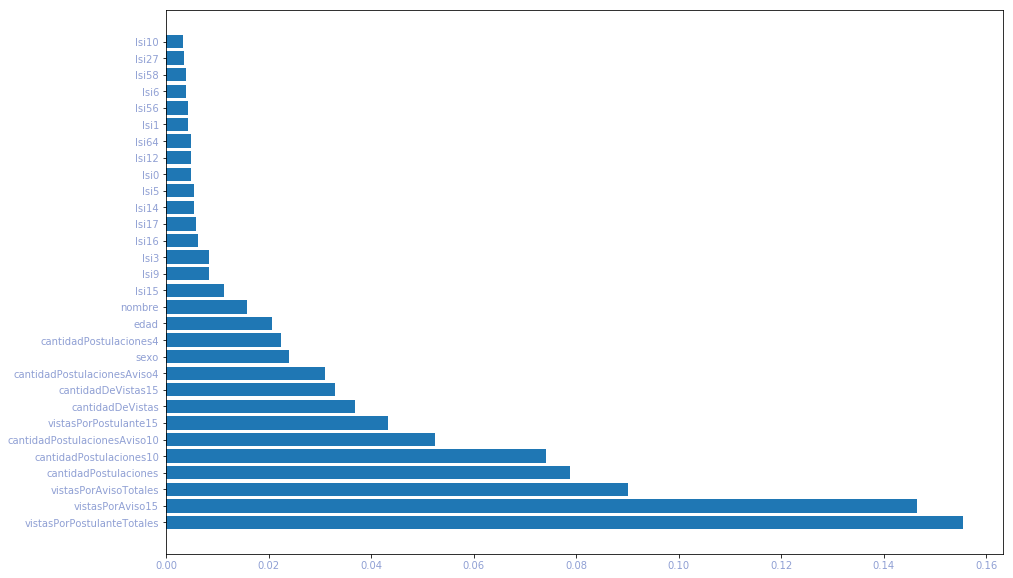

In [9]:
#######################################
toplot = pd.DataFrame(train.columns.values,xgb1.feature_importances_).reset_index()
toplot.columns = ['importancia','features']
toplot = toplot.sort_values(by='importancia',ascending=False)[0:30]
plt.figure(figsize=(15,10))
plt.xticks(rotation=0,fontsize=10,color='#90A0D4')
plt.yticks(fontsize=10,color='#90A0D4')
plt.barh(toplot['features'],toplot['importancia'])

In [10]:
predic = xgb1.predict_proba(test) 
predic[:,1].mean()

0.37957755

In [11]:
submit = pd.DataFrame()
submit['id'] = testid
submit['sepostulo'] = predic[:,1]
submit['id'] = submit['id'].apply(int)
submit.to_csv('/home/pcsor/facu/TP2/submit1.csv',index=False)

#### Serializacion del modelo

In [44]:
from sklearn.externals import joblib
joblib.dump(xgb1,basepath + '/.pkl') 

['/home/pcsor/facu/TP2/98069.pkl']

#### KMEANS

* filtro los features con poca importancia 
* agrego la distancia de cada texto a los n cluster
    resultantes de aplicar kmeans con k=50

In [12]:
titulos = pd.read_csv(basepath + '/tituloskmeans.csv',low_memory=False)
train = train[toplot['features'].values]
test = test[toplot['features'].values]

In [13]:
train['idaviso'] = trainidap['idaviso']
test['idaviso'] = testidap['idaviso']

In [16]:
train.columns,test.columns

(Index(['vistasPorPostulanteTotales', 'vistasPorAviso15',
        'vistasPorAvisoTotales', 'cantidadPostulaciones',
        'cantidadPostulaciones10', 'cantidadPostulacionesAviso10',
        'vistasPorPostulante15', 'cantidadDeVistas', 'cantidadDeVistas15',
        'cantidadPostulacionesAviso4', 'sexo', 'cantidadPostulaciones4', 'edad',
        'nombre', 'lsi15', 'lsi9', 'lsi3', 'lsi16', 'lsi17', 'lsi14', 'lsi5',
        'lsi0', 'lsi12', 'lsi64', 'lsi1', 'lsi56', 'lsi6', 'lsi58', 'lsi27',
        'lsi10', 'idaviso', 'kmeans0', 'kmeans1', 'kmeans2', 'kmeans3',
        'kmeans4', 'kmeans5', 'kmeans6', 'kmeans7', 'kmeans8', 'kmeans9',
        'kmeans10', 'kmeans11', 'kmeans12', 'kmeans13', 'kmeans14', 'kmeans15',
        'kmeans16', 'kmeans17', 'kmeans18', 'kmeans19', 'kmeans20', 'kmeans21',
        'kmeans22', 'kmeans23', 'kmeans24', 'kmeans25', 'kmeans26', 'kmeans27',
        'kmeans28', 'kmeans29', 'kmeans30', 'kmeans31', 'kmeans32', 'kmeans33',
        'kmeans34', 'kmeans35', 'kmeans3

In [23]:
train = pd.merge(train,titulos,how='left',on='idaviso',indicator=True)
train = train.query('_merge != "left_only"')
train = train.drop(['_merge'],axis=1)
test = pd.merge(test,titulos,how='left',on='idaviso')
test = test.drop(['idaviso'],axis=1)
train = train.drop(['idaviso'],axis=1)

In [31]:
xgb1 = xgb.XGBClassifier(eval_metric='auc',n_jobs=4,silent=False,n_estimators=100,max_depth=5)
xgb1.fit(train,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

<BarContainer object of 50 artists>

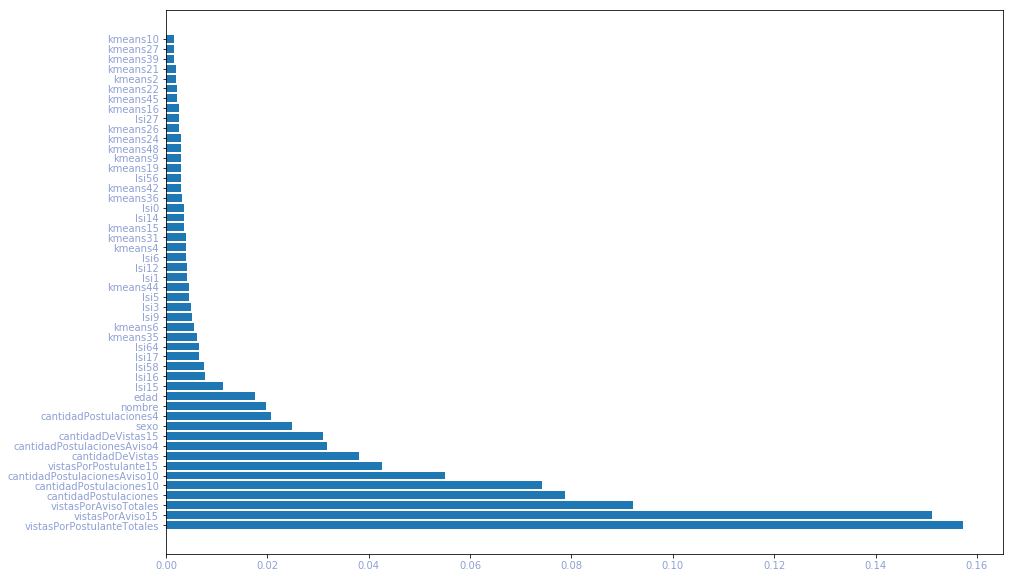

In [34]:
toplot = pd.DataFrame(train.columns.values,xgb1.feature_importances_).reset_index()
toplot.columns = ['importancia','features']
toplot = toplot.sort_values(by='importancia',ascending=False)[0:50]
plt.figure(figsize=(15,10))
plt.xticks(rotation=0,fontsize=10,color='#90A0D4')
plt.yticks(fontsize=10,color='#90A0D4')
plt.barh(toplot['features'],toplot['importancia'])

In [33]:
predic = xgb1.predict_proba(test) 
predic[:,1].mean()

0.37414742

In [30]:
x = test.values
columns = test.keys()
min_max_scaler = MinMaxScaler()
x = min_max_scaler.fit_transform(x)
test = pd.DataFrame(x)
test.columns = columns
#################################
x = train.values
columns = train.keys()
min_max_scaler = MinMaxScaler()
x = min_max_scaler.fit_transform(x)
train = pd.DataFrame(x)
train.columns = columns

In [35]:
submit = pd.DataFrame()
submit['id'] = testid
submit['sepostulo'] = predic[:,1]
submit['id'] = submit['id'].apply(int)
submit.to_csv('/home/pcsor/facu/TP2/submit2.csv',index=False)